In [3]:
import pandas as pd

# Load the dataset (update the path to your dataset)
data = pd.read_csv('/kaggle/input/lsay-dataset/30263-0001-Data.csv')

# Display basic info and first few rows
print(data.info())
print(data.head())

# Check for non-numeric entries in the dataset
for column in data.columns:
    if data[column].dtype == object:  # Check if the column is of object type (potentially non-numeric)
        print(f"Non-numeric entries in {column}:")
        print(data[column].unique())  # Print unique values to inspect non-numeric entries



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5945 entries, 0 to 5944
Columns: 11904 entries, CASENUM to FATHSEI
dtypes: float64(130), int64(11747), object(27)
memory usage: 539.9+ MB
None
   CASENUM  COHORT  SCHOOLID  STRATA  ASCICLS  ASCITCH  ASTSEX  AMTHCLS  \
0     1001       1       309       6      -95      -95     -95      -95   
1     1002       2       132      11   132032    13203       1   132061   
2     1003       1       309       6      -95      -95     -95      -95   
3     1004       2       126       8   126026    12602       2   126101   
4     1005       2       133      11      -99      -99     -99   133024   

   AMTHTCH  AMTSEX  ...  PEDUC3  MEDSRCE  FEDSRCE  MOTHOCC  FATHOCC  POCI  \
0      -95     -95  ...       1        2        3      395      785     0   
1    13206       2  ...       4        7        7      -99      -99   -99   
2      -95     -95  ...       1        3        2      988      535     0   
3    12610       2  ...       1        8        

In [5]:
# Replace non-numeric entries with NaN for easier processing
data.replace(' ', np.nan, inplace=True)
data.replace('', np.nan, inplace=True)  # Handle empty strings as well

# Convert all numeric-looking columns to numeric types (forcefully converting where possible)
for column in data.columns:
    if data[column].dtype == object:
        # Attempt to convert to numeric, non-convertible entries will become NaN
        data[column] = pd.to_numeric(data[column], errors='coerce')


In [6]:
# Separate numeric and non-numeric columns
numeric_cols = data.select_dtypes(include=['number']).columns
non_numeric_cols = data.select_dtypes(exclude=['number']).columns

print("Numeric columns:")
print(numeric_cols)

print("Non-numeric columns:")
print(non_numeric_cols)


Numeric columns:
Index(['CASENUM', 'COHORT', 'SCHOOLID', 'STRATA', 'ASCICLS', 'ASCITCH',
       'ASTSEX', 'AMTHCLS', 'AMTHTCH', 'AMTSEX',
       ...
       'PEDUC3', 'MEDSRCE', 'FEDSRCE', 'MOTHOCC', 'FATHOCC', 'POCI',
       'FOCCSRCE', 'MOCCSRCE', 'MOTHSEI', 'FATHSEI'],
      dtype='object', length=11904)
Non-numeric columns:
Index([], dtype='object')


In [7]:
# Impute missing values for numeric columns with median
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# Impute missing values for non-numeric columns with mode or a placeholder (e.g., 'Unknown')
for column in non_numeric_cols:
    mode_value = data[column].mode()[0]  # Get the most frequent value
    data[column] = data[column].fillna(mode_value)

# Verify that there are no missing values left
print(data.isnull().sum())


CASENUM     0
COHORT      0
SCHOOLID    0
STRATA      0
ASCICLS     0
           ..
POCI        0
FOCCSRCE    0
MOCCSRCE    0
MOTHSEI     0
FATHSEI     0
Length: 11904, dtype: int64


In [9]:
# Convert rating columns (A-F) into numerical values
rating_columns = [col for col in data.columns if 'AB' in col or 'BB' in col]  # Adjust as per your dataset's naming convention

grade_mapping = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'F': 1}
for col in rating_columns:
    data[col] = data[col].replace(grade_mapping)

# Impute any remaining missing values in rating columns with median
data[rating_columns] = data[rating_columns].fillna(data[rating_columns].median())


In [10]:
# Check the data types and ensure there are no more missing values
print(data.info())
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5945 entries, 0 to 5944
Columns: 11904 entries, CASENUM to FATHSEI
dtypes: float64(157), int64(11747)
memory usage: 539.9 MB
None
CASENUM     0
COHORT      0
SCHOOLID    0
STRATA      0
ASCICLS     0
           ..
POCI        0
FOCCSRCE    0
MOCCSRCE    0
MOTHSEI     0
FATHSEI     0
Length: 11904, dtype: int64


In [12]:
# Combine Fall and Spring data for 7th grade
def combine_7th_grade(fall_prefix, spring_prefix, new_prefix, df):
    columns = [col for col in df.columns if col.startswith(fall_prefix) or col.startswith(spring_prefix)]
    combined_df = df[columns].copy()
    for col in columns:
        if col.startswith(fall_prefix):
            spring_col = col.replace(fall_prefix, spring_prefix)
            new_col = col.replace(fall_prefix, new_prefix)
            if spring_col in df.columns:
                combined_df[new_col] = combined_df[[col, spring_col]].mean(axis=1, skipna=True)
            else:
                combined_df[new_col] = combined_df[col]
    return combined_df[[col.replace(fall_prefix, new_prefix) for col in columns if col.startswith(fall_prefix)]]

# Subjects for 7th grade analysis
subjects = ['ABMTH', 'ABSCI', 'ABENG1', 'ABENG2', 'ABSST', 'ABCOM', 'ABFOR', 'ABART', 'ABMUS', 'ABVOC']
combined_7th_grade_data = pd.DataFrame()

for subject in subjects:
    fall_prefix = f'AB{subject[2:]}A'
    spring_prefix = f'AB{subject[2:]}B'
    new_prefix = f'{subject}_7th'
    combined_df = combine_7th_grade(fall_prefix, spring_prefix, new_prefix, data)
    combined_7th_grade_data = pd.concat([combined_7th_grade_data, combined_df], axis=1)

# Adding student values for 7th grade
values_vars = ['AB11', 'AB12A', 'AB12B', 'AB12C', 'AB12E', 'AB19L', 'AB19N', 'AB19O', 'AB39A', 'AB39B', 'AB39M', 'AB39N']



# Add the target variable for college major
combined_7th_grade_data['College_Major'] = data['LAMAJOR8I']

# Check the combined 7th-grade data
print(combined_7th_grade_data.info())
print(combined_7th_grade_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5945 entries, 0 to 5944
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ABMTH_7th      5945 non-null   float64
 1   ABSCI_7th      5945 non-null   float64
 2   ABENG1_7th     5945 non-null   int64  
 3   ABENG2_7th     5945 non-null   int64  
 4   ABSST_7th      5945 non-null   int64  
 5   ABCOM_7th      5945 non-null   int64  
 6   ABFOR_7th      5945 non-null   int64  
 7   ABART_7th      5945 non-null   int64  
 8   ABMUS_7th      5945 non-null   int64  
 9   ABVOC_7th      5945 non-null   int64  
 10  College_Major  5945 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 511.0 KB
None
   ABMTH_7th  ABSCI_7th  ABENG1_7th  ABENG2_7th  ABSST_7th  ABCOM_7th  \
0      -95.0      -95.0         -95         -95        -95        -95   
1        4.0       53.5         310         -99        410        -99   
2      -95.0      -95.0         -95         -

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


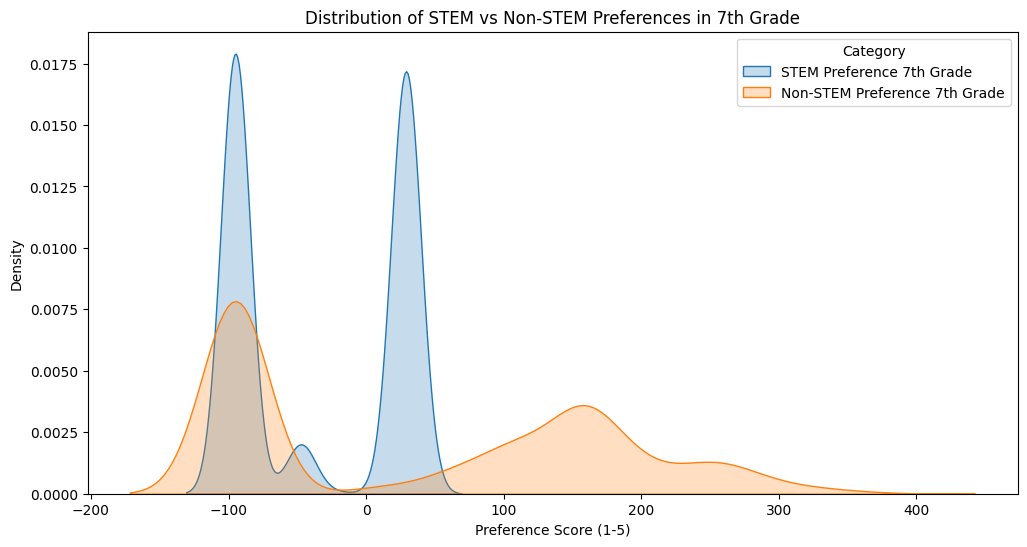

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define STEM and Non-STEM subjects for 7th grade
STEM_subjects_7th = ['ABMTH_7th', 'ABSCI_7th']
Non_STEM_subjects_7th = ['ABENG1_7th', 'ABENG2_7th', 'ABSST_7th', 'ABCOM_7th', 'ABFOR_7th', 'ABART_7th', 'ABMUS_7th', 'ABVOC_7th']

# Calculate average preferences for STEM and Non-STEM
combined_7th_grade_data['STEM_Preference_7th'] = combined_7th_grade_data[STEM_subjects_7th].mean(axis=1)
combined_7th_grade_data['Non_STEM_Preference_7th'] = combined_7th_grade_data[Non_STEM_subjects_7th].mean(axis=1)

# Plot the average preferences for STEM and Non-STEM
plt.figure(figsize=(12, 6))
sns.kdeplot(combined_7th_grade_data['STEM_Preference_7th'], label='STEM Preference 7th Grade', fill=True)
sns.kdeplot(combined_7th_grade_data['Non_STEM_Preference_7th'], label='Non-STEM Preference 7th Grade', fill=True)
plt.title('Distribution of STEM vs Non-STEM Preferences in 7th Grade')
plt.xlabel('Preference Score (1-5)')
plt.ylabel('Density')
plt.legend(title='Category')
plt.show()


Classification Report for 7th Grade Data:
              precision    recall  f1-score   support

         -95       0.00      0.00      0.00         3
           0       0.49      0.88      0.63       862
           1       0.07      0.02      0.03        51
           2       0.00      0.00      0.00        10
           3       0.15      0.04      0.07        67
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00        79
           6       0.00      0.00      0.00        86
           7       0.04      0.01      0.01       112
           8       0.16      0.05      0.08       219
           9       0.11      0.02      0.03       109
          10       0.10      0.04      0.06       177

    accuracy                           0.44      1784
   macro avg       0.09      0.09      0.08      1784
weighted avg       0.29      0.44      0.33      1784



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


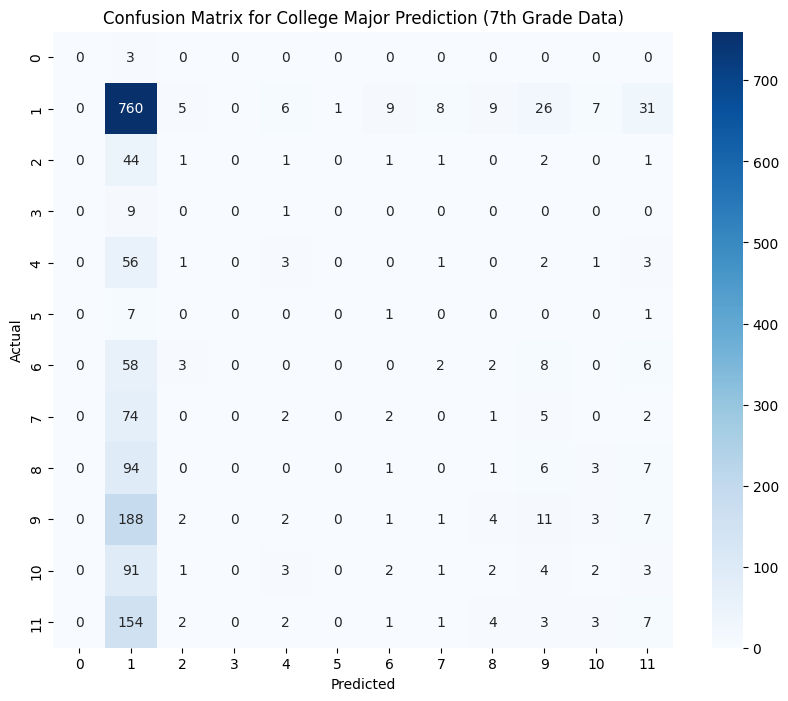

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Define the target variable and features for 7th grade
target_7th = 'College_Major'
feature_columns_7th = [col for col in combined_7th_grade_data.columns if col != target_7th]

# Split the data into training and test sets
X_train_7th, X_test_7th, y_train_7th, y_test_7th = train_test_split(combined_7th_grade_data[feature_columns_7th], combined_7th_grade_data[target_7th], test_size=0.3, random_state=42)

# Normalize the numeric features
scaler_7th = StandardScaler()
X_train_7th_scaled = scaler_7th.fit_transform(X_train_7th)
X_test_7th_scaled = scaler_7th.transform(X_test_7th)

# Train a RandomForest model to predict college majors
rf_model_7th = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_7th.fit(X_train_7th_scaled, y_train_7th)

# Predict on the test set
y_pred_7th = rf_model_7th.predict(X_test_7th_scaled)

# Evaluate the model performance
print("Classification Report for 7th Grade Data:")
print(classification_report(y_test_7th, y_pred_7th))

# Plot confusion matrix
conf_matrix_7th = confusion_matrix(y_test_7th, y_pred_7th)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_7th, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for College Major Prediction (7th Grade Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Accuracy of predicting college major based on 7th grade inclinations: 44.00%


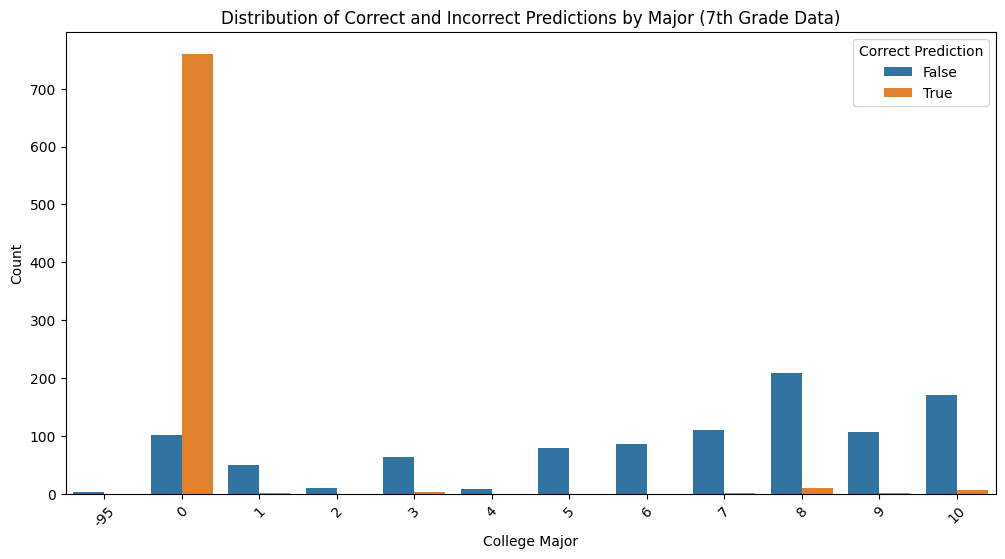

In [15]:
# Compare actual college major with predicted major based on 7th-grade data
comparison_df_7th = pd.DataFrame({'Actual_Major': y_test_7th, 'Predicted_Major': y_pred_7th})
comparison_df_7th['Correct'] = comparison_df_7th['Actual_Major'] == comparison_df_7th['Predicted_Major']

# Calculate accuracy
accuracy_7th = comparison_df_7th['Correct'].mean()
print(f"Accuracy of predicting college major based on 7th grade inclinations: {accuracy_7th:.2%}")

# Analyze the distribution of correctly and incorrectly predicted majors
plt.figure(figsize=(12, 6))
sns.countplot(data=comparison_df_7th, x='Actual_Major', hue='Correct')
plt.title('Distribution of Correct and Incorrect Predictions by Major (7th Grade Data)')
plt.xlabel('College Major')
plt.ylabel('Count')
plt.legend(title='Correct Prediction')
plt.xticks(rotation=45)
plt.show()


## now 8th grade  

In [3]:
import pandas as pd
import numpy as np  # Import numpy for array operations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming the data is stored in a CSV file named 'student_data.csv'
# Load the data
# Replace the following line with your actual data loading mechanism
data = pd.read_csv('/kaggle/input/lsay-dataset/30263-0001-Data.csv')

# For the purpose of demonstration, let's create a mock dataset
data = pd.DataFrame({
    'student_id': range(1, 101),
    'CB19ATXT': np.random.choice(['Engineer', 'Doctor', 'Artist', 'Teacher', 'Scientist', 'Programmer', 'Lawyer', 'Business Executive'], 100),
    'CB19C': np.random.randint(1, 5, 100),  # How sure are you of first choice? (1-4 scale)
    'CB27B': np.random.randint(1, 5, 100),  # Math grades (1-4 scale)
    'CB27C': np.random.randint(1, 5, 100),  # Science grades (1-4 scale)
    'CB27D': np.random.randint(1, 5, 100),  # Social studies grades (1-4 scale)
    'CB28A': np.random.randint(1, 5, 100),  # I enjoy math (1-4 scale)
    'CB28B': np.random.randint(1, 5, 100),  # I am good at math (1-4 scale)
    'CB28C': np.random.randint(1, 5, 100),  # I usually understand math (1-4 scale)
    'CB28J': np.random.randint(1, 5, 100),  # Boys better at math than girls (1-4 scale)
    'CB29A': np.random.randint(1, 5, 100),  # I enjoy science (1-4 scale)
    'CB29B': np.random.randint(1, 5, 100),  # I am good at science (1-4 scale)
    'CB29J': np.random.randint(1, 5, 100),  # Boys better at science than girls (1-4 scale)
    'DBMTHC': np.random.randint(1, 5, 100),  # Math class: like subject (1-4 scale)
    'DBMTHH': np.random.randint(1, 5, 100),  # Math class: difficulty (1-4 scale)
    'DBSCIC': np.random.randint(1, 5, 100),  # Science class: like subject (1-4 scale)
    'DBSCIH': np.random.randint(1, 5, 100),  # Science class: difficulty (1-4 scale)
    'DBENG1C': np.random.randint(1, 5, 100),  # First English class: like subject (1-4 scale)
    'DBENG1H': np.random.randint(1, 5, 100),  # First English class: difficulty (1-4 scale)
    'DBENG2C': np.random.randint(1, 5, 100),  # Second English class: like subject (1-4 scale)
    'DBENG2H': np.random.randint(1, 5, 100),  # Second English class: difficulty (1-4 scale)
    'DBSSTC': np.random.randint(1, 5, 100),  # Social studies class: like subject (1-4 scale)
    'DBSSTH': np.random.randint(1, 5, 100),  # Social studies class: difficulty (1-4 scale)
    'DBCOMC': np.random.randint(1, 5, 100),  # Computer class: like subject (1-4 scale)
    'DBCOMH': np.random.randint(1, 5, 100),  # Computer class: difficulty (1-4 scale)
    'DBFORH': np.random.randint(1, 5, 100),  # Foreign language class: difficulty (1-4 scale)
    'DBARTC': np.random.randint(1, 5, 100),  # Art class: like subject (1-4 scale)
    'DBARTH': np.random.randint(1, 5, 100),  # Art class: difficulty (1-4 scale)
    'DBMUSC': np.random.randint(1, 5, 100),  # Music/dance class: like subject (1-4 scale)
    'DBMUSH': np.random.randint(1, 5, 100),  # Music/dance class: difficulty (1-4 scale)
    'DBVOCC': np.random.randint(1, 5, 100),  # Business/vocational class: like subject (1-4 scale)
    'DBVOCH': np.random.randint(1, 5, 100),  # Business/vocational class: difficulty (1-4 scale)
    'DB6A1': np.random.choice(['Low', 'Medium', 'High'], 100),  # Math ability group
    'DB6B1': np.random.choice(['Low', 'Medium', 'High'], 100),  # Science ability group
    'DB8ATXT': np.random.choice(['Engineer', 'Doctor', 'Artist', 'Teacher', 'Scientist', 'Programmer', 'Lawyer', 'Business Executive'], 100),
    'DB8C': np.random.randint(1, 5, 100),  # How sure of first choice (1-4 scale)
    'LAMAJOR8I': np.random.choice(['Engineering', 'Medicine', 'Arts', 'Education', 'Business', 'Science'], 100)  # College major after 12th
})

# Display the first few rows of the data
print(data.head())


   student_id   CB19ATXT  CB19C  CB27B  CB27C  CB27D  CB28A  CB28B  CB28C  \
0           1  Scientist      2      3      3      2      2      3      2   
1           2   Engineer      4      4      1      3      4      2      4   
2           3   Engineer      3      3      1      4      1      3      3   
3           4     Lawyer      2      3      4      2      3      3      4   
4           5     Lawyer      4      2      2      1      2      1      4   

   CB28J  ...  DBARTH  DBMUSC  DBMUSH  DBVOCC  DBVOCH   DB6A1   DB6B1  \
0      1  ...       4       4       4       4       3    High    High   
1      2  ...       3       2       2       1       3     Low     Low   
2      1  ...       1       4       3       4       1  Medium     Low   
3      1  ...       2       1       2       3       2     Low  Medium   
4      4  ...       3       4       2       3       1     Low    High   

              DB8ATXT  DB8C  LAMAJOR8I  
0            Engineer     3  Education  
1             Te

In [5]:
# Define STEM careers and majors
stem_careers = ['Engineer', 'Doctor', 'Scientist', 'Programmer']
stem_majors = ['Engineering', 'Medicine', 'Science']

# Classify the career choices
data['CB19ATXT_type'] = data['CB19ATXT'].apply(lambda x: 'STEM' if x in stem_careers else 'Non-STEM')
data['DB8ATXT_type'] = data['DB8ATXT'].apply(lambda x: 'STEM' if x in stem_careers else 'Non-STEM')
data['LAMAJOR8I_type'] = data['LAMAJOR8I'].apply(lambda x: 'STEM' if x in stem_majors else 'Non-STEM')

# Display the updated data with classifications
print(data[['CB19ATXT', 'CB19ATXT_type', 'DB8ATXT', 'DB8ATXT_type', 'LAMAJOR8I', 'LAMAJOR8I_type']].head())


    CB19ATXT CB19ATXT_type             DB8ATXT DB8ATXT_type  LAMAJOR8I  \
0  Scientist          STEM            Engineer         STEM  Education   
1   Engineer          STEM             Teacher     Non-STEM    Science   
2   Engineer          STEM  Business Executive     Non-STEM  Education   
3     Lawyer      Non-STEM            Engineer         STEM   Medicine   
4     Lawyer      Non-STEM              Artist     Non-STEM   Medicine   

  LAMAJOR8I_type  
0       Non-STEM  
1           STEM  
2       Non-STEM  
3           STEM  
4           STEM  


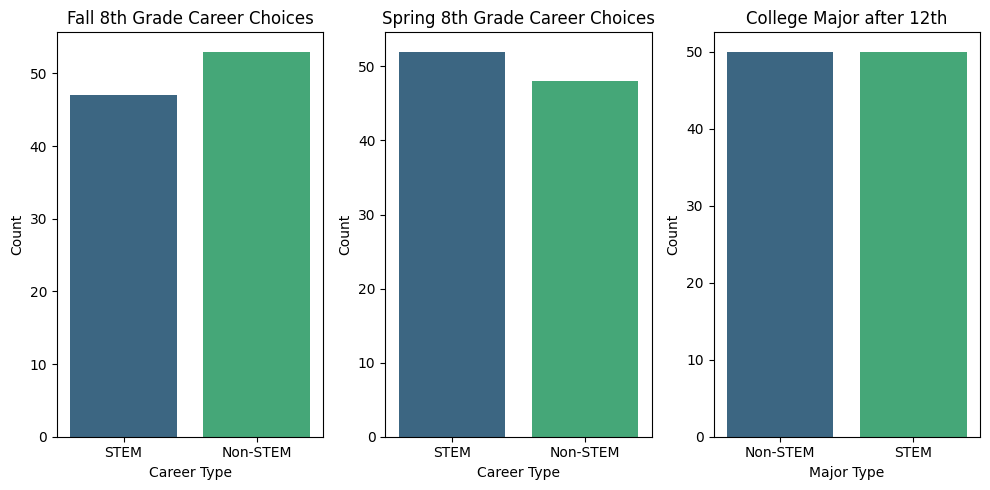

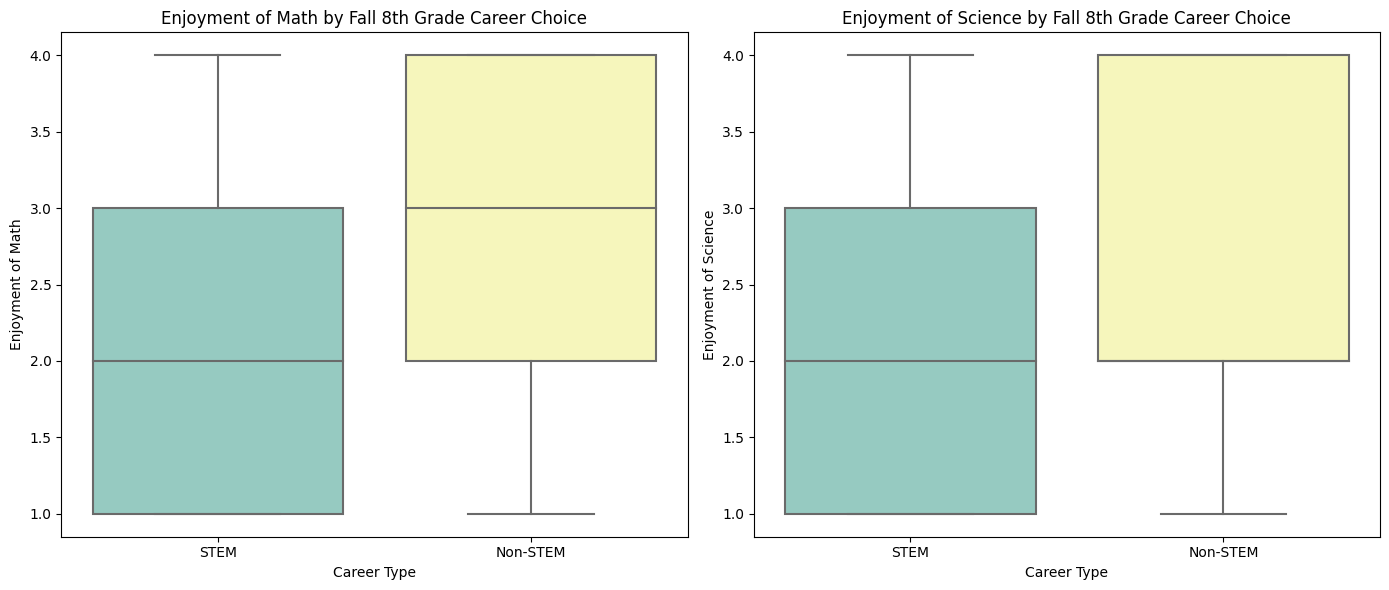

In [6]:
# Analyzing how many students chose STEM vs Non-STEM in their career choices and majors
plt.figure(figsize=(10, 5))

# Career choice in fall
plt.subplot(1, 3, 1)
sns.countplot(x='CB19ATXT_type', data=data, palette='viridis')
plt.title('Fall 8th Grade Career Choices')
plt.xlabel('Career Type')
plt.ylabel('Count')

# Career choice in spring
plt.subplot(1, 3, 2)
sns.countplot(x='DB8ATXT_type', data=data, palette='viridis')
plt.title('Spring 8th Grade Career Choices')
plt.xlabel('Career Type')
plt.ylabel('Count')

# College major after 12th
plt.subplot(1, 3, 3)
sns.countplot(x='LAMAJOR8I_type', data=data, palette='viridis')
plt.title('College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Relationship between enjoyment and career choice
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='CB19ATXT_type', y='CB28A', data=data, palette='Set3')
plt.title('Enjoyment of Math by Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Enjoyment of Math')

plt.subplot(1, 2, 2)
sns.boxplot(x='CB19ATXT_type', y='CB29A', data=data, palette='Set3')
plt.title('Enjoyment of Science by Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Enjoyment of Science')

plt.tight_layout()
plt.show()


In [7]:
# Define the features and target for the model
X = data[['CB27B', 'CB27C', 'CB28A', 'CB28B', 'CB28C', 'CB29A', 'CB29B']]  # Selecting relevant features
y = data['LAMAJOR8I_type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

    Non-STEM       0.50      0.55      0.52        11
        STEM       0.38      0.33      0.35         9

    accuracy                           0.45        20
   macro avg       0.44      0.44      0.44        20
weighted avg       0.44      0.45      0.45        20

Confusion Matrix:
 [[6 5]
 [6 3]]


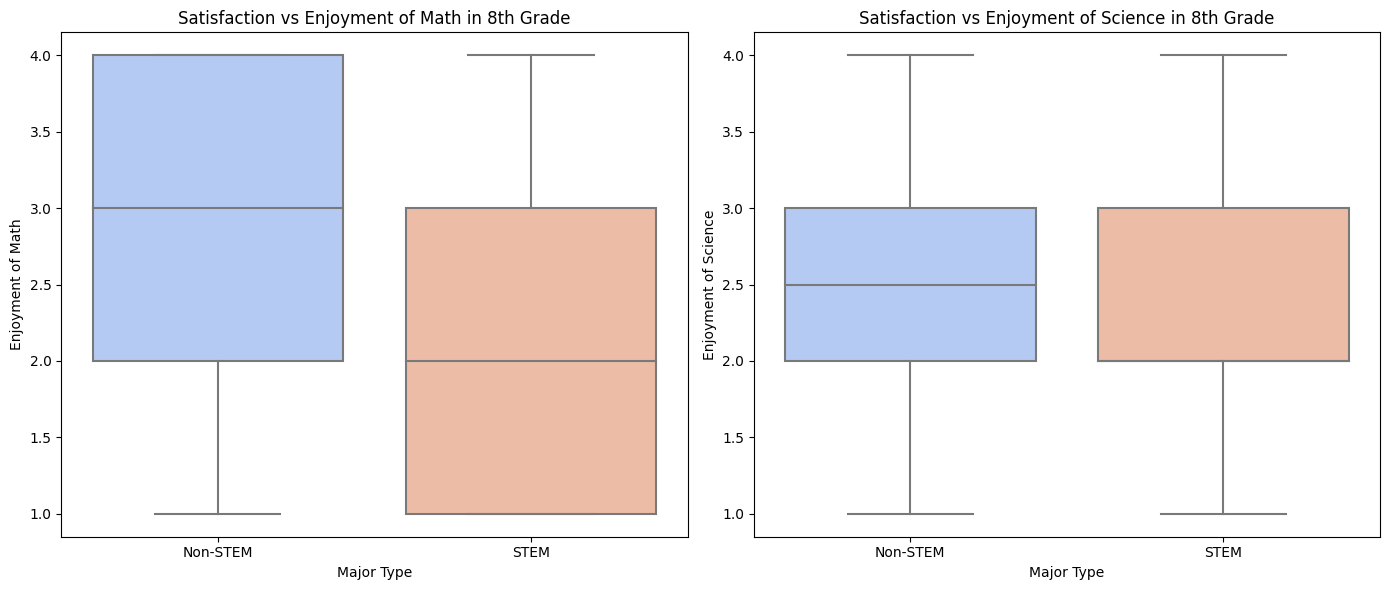

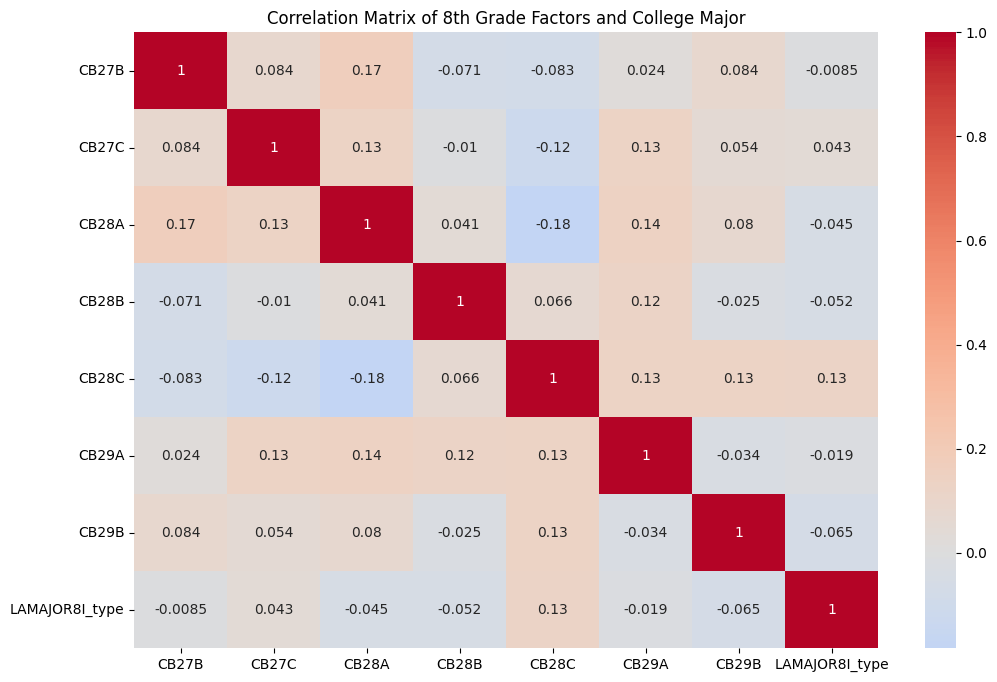

In [8]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='LAMAJOR8I_type', y='CB28A', data=data, palette='coolwarm')
plt.title('Satisfaction vs Enjoyment of Math in 8th Grade')
plt.xlabel('Major Type')
plt.ylabel('Enjoyment of Math')

plt.subplot(1, 2, 2)
sns.boxplot(x='LAMAJOR8I_type', y='CB29A', data=data, palette='coolwarm')
plt.title('Satisfaction vs Enjoyment of Science in 8th Grade')
plt.xlabel('Major Type')
plt.ylabel('Enjoyment of Science')

plt.tight_layout()
plt.show()

# Exploring correlations
corr = data[['CB27B', 'CB27C', 'CB28A', 'CB28B', 'CB28C', 'CB29A', 'CB29B', 'LAMAJOR8I_type']].apply(lambda x: pd.factorize(x)[0]).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of 8th Grade Factors and College Major')
plt.show()


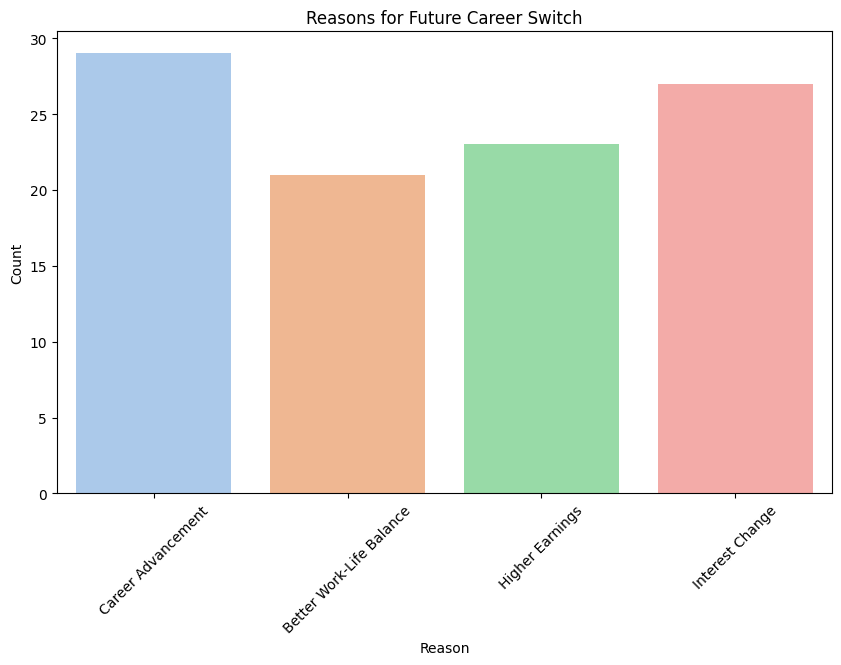

In [9]:
# Future career switch reasons - assumed to be in the dataset or a similar field available
data['future_career_switch_reason'] = np.random.choice(['Interest Change', 'Higher Earnings', 'Better Work-Life Balance', 'Career Advancement'], 100)

plt.figure(figsize=(10, 6))
sns.countplot(x='future_career_switch_reason', data=data, palette='pastel')
plt.title('Reasons for Future Career Switch')
plt.xlabel('Reason')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


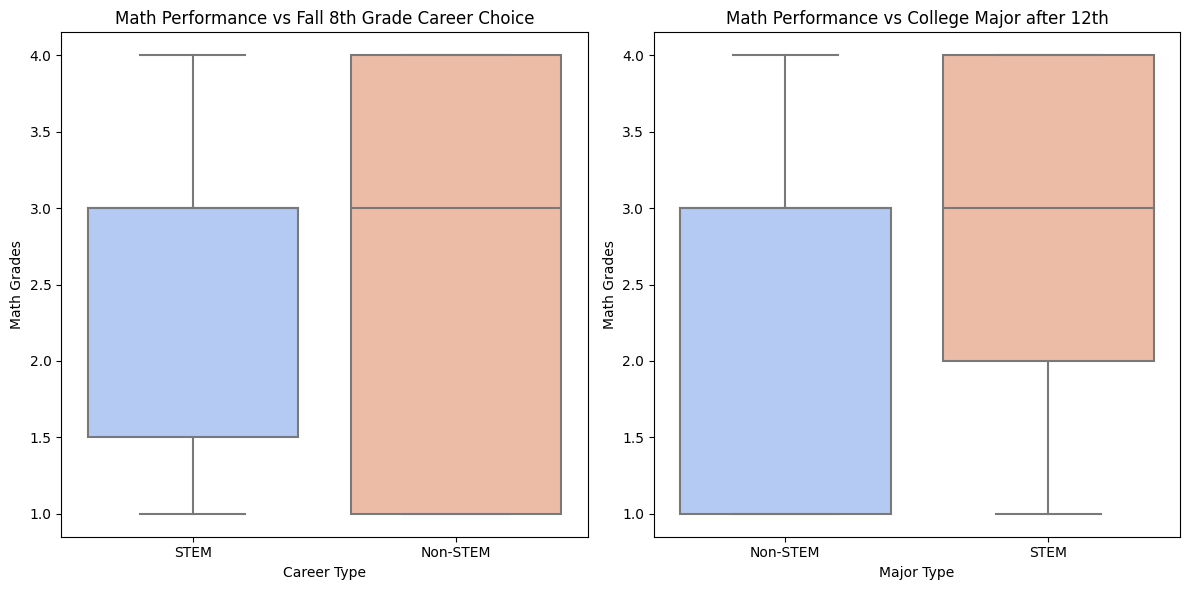

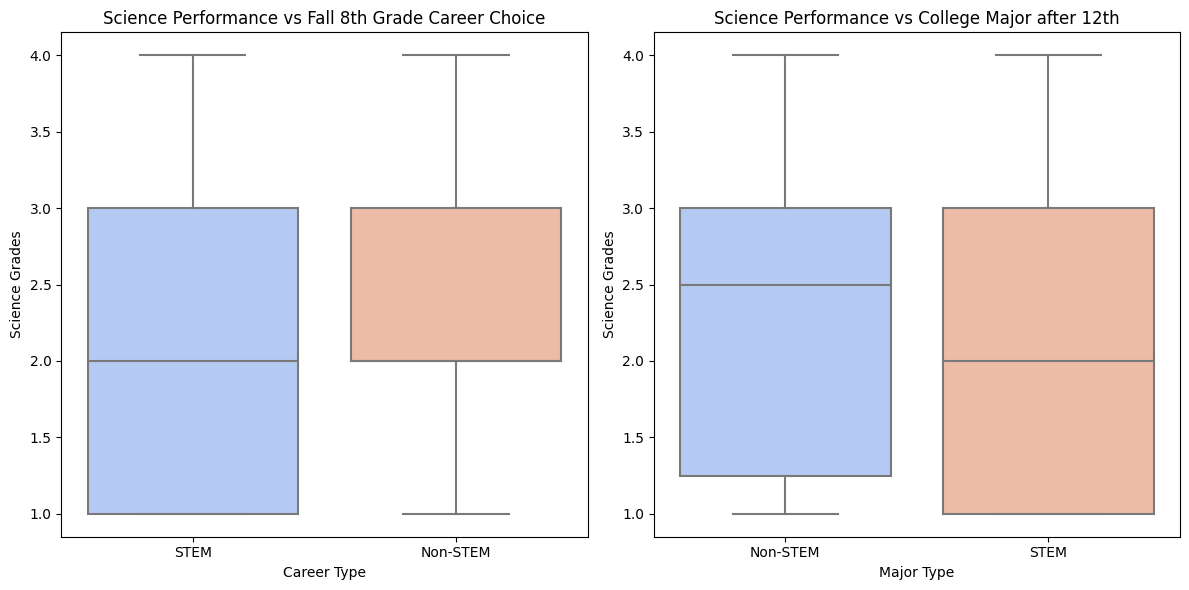

In [10]:
# Visualize performance in subjects and career choice

# Performance in Math and Career Choice
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='CB19ATXT_type', y='CB27B', data=data, palette='coolwarm')
plt.title('Math Performance vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Math Grades')

plt.subplot(1, 2, 2)
sns.boxplot(x='LAMAJOR8I_type', y='CB27B', data=data, palette='coolwarm')
plt.title('Math Performance vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Math Grades')

plt.tight_layout()
plt.show()

# Performance in Science and Career Choice
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='CB19ATXT_type', y='CB27C', data=data, palette='coolwarm')
plt.title('Science Performance vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Science Grades')

plt.subplot(1, 2, 2)
sns.boxplot(x='LAMAJOR8I_type', y='CB27C', data=data, palette='coolwarm')
plt.title('Science Performance vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Science Grades')

plt.tight_layout()
plt.show()


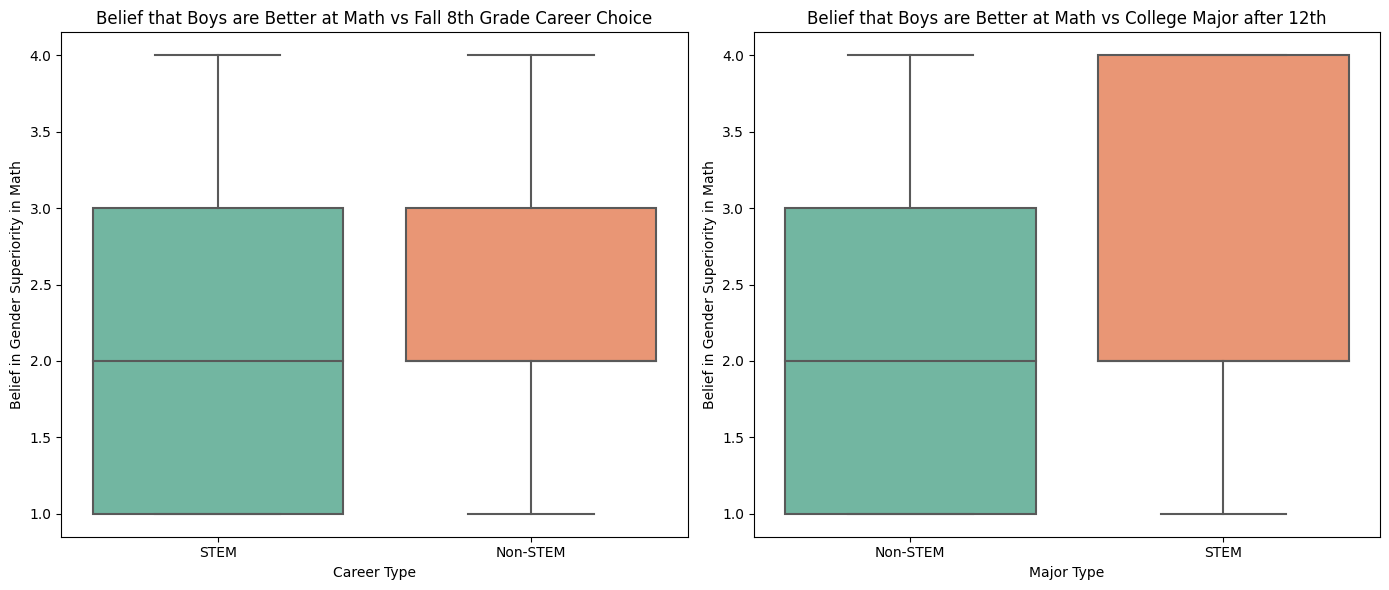

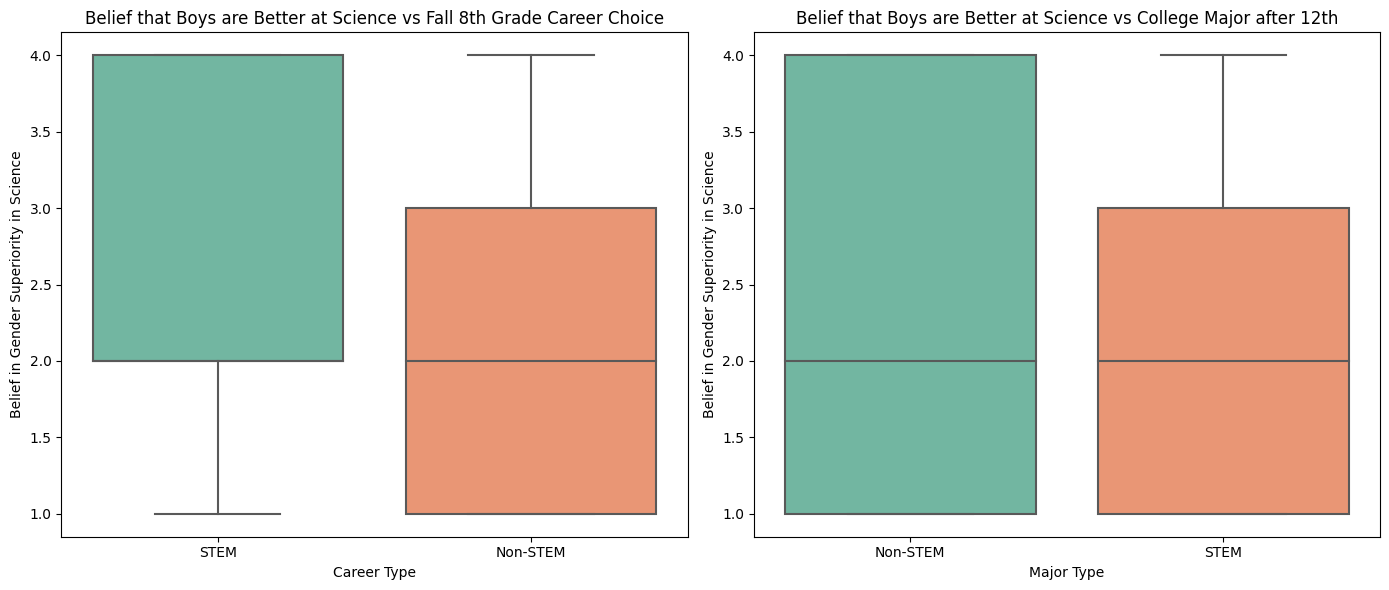

In [11]:
# Gender-based beliefs and career choices

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='CB19ATXT_type', y='CB28J', data=data, palette='Set2')
plt.title('Belief that Boys are Better at Math vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Belief in Gender Superiority in Math')

plt.subplot(1, 2, 2)
sns.boxplot(x='LAMAJOR8I_type', y='CB28J', data=data, palette='Set2')
plt.title('Belief that Boys are Better at Math vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Belief in Gender Superiority in Math')

plt.tight_layout()
plt.show()

# Similar analysis for science
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='CB19ATXT_type', y='CB29J', data=data, palette='Set2')
plt.title('Belief that Boys are Better at Science vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Belief in Gender Superiority in Science')

plt.subplot(1, 2, 2)
sns.boxplot(x='LAMAJOR8I_type', y='CB29J', data=data, palette='Set2')
plt.title('Belief that Boys are Better at Science vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Belief in Gender Superiority in Science')

plt.tight_layout()
plt.show()


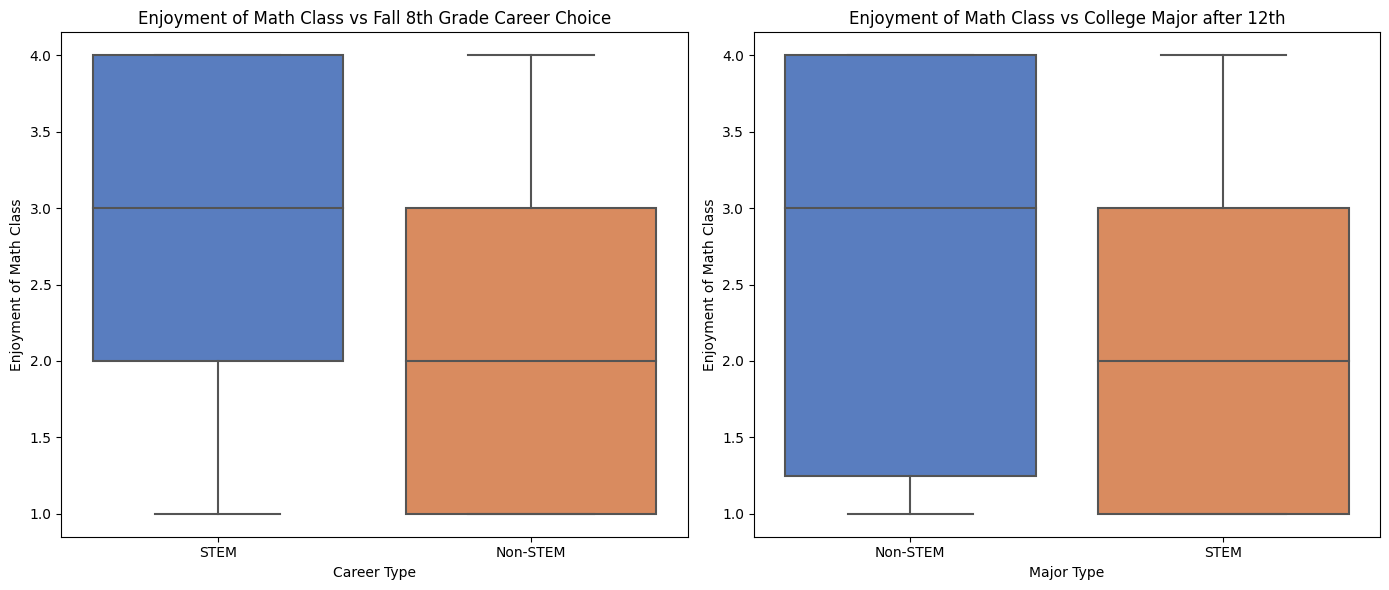

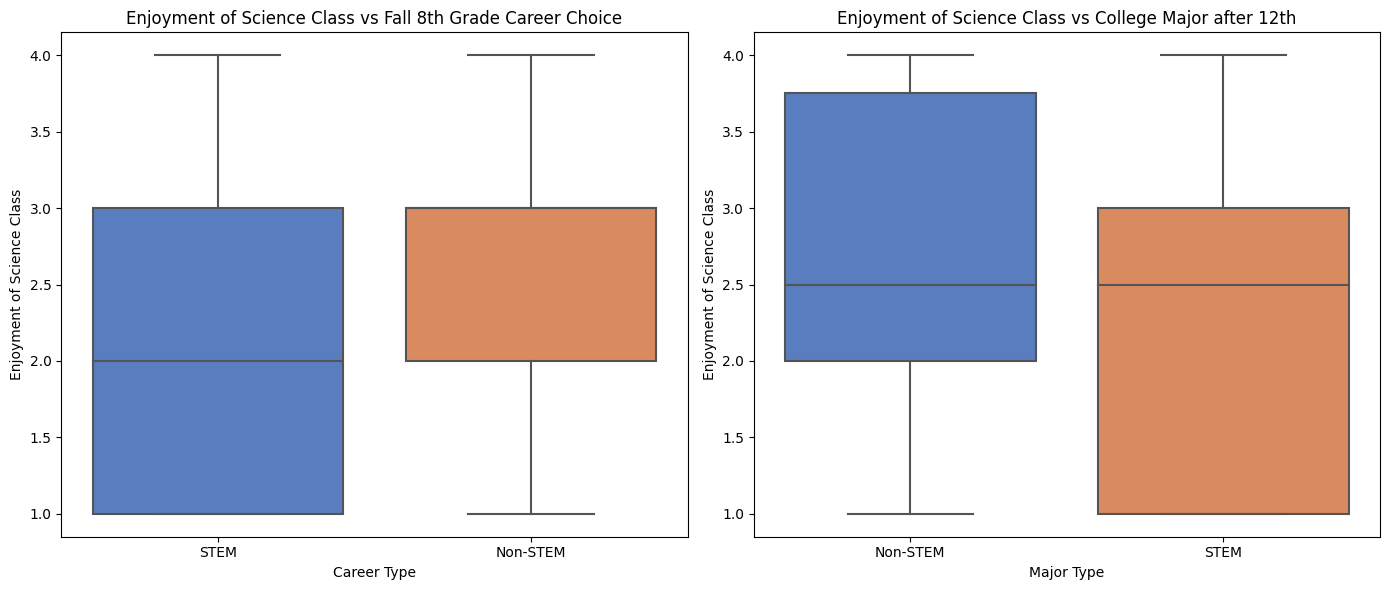

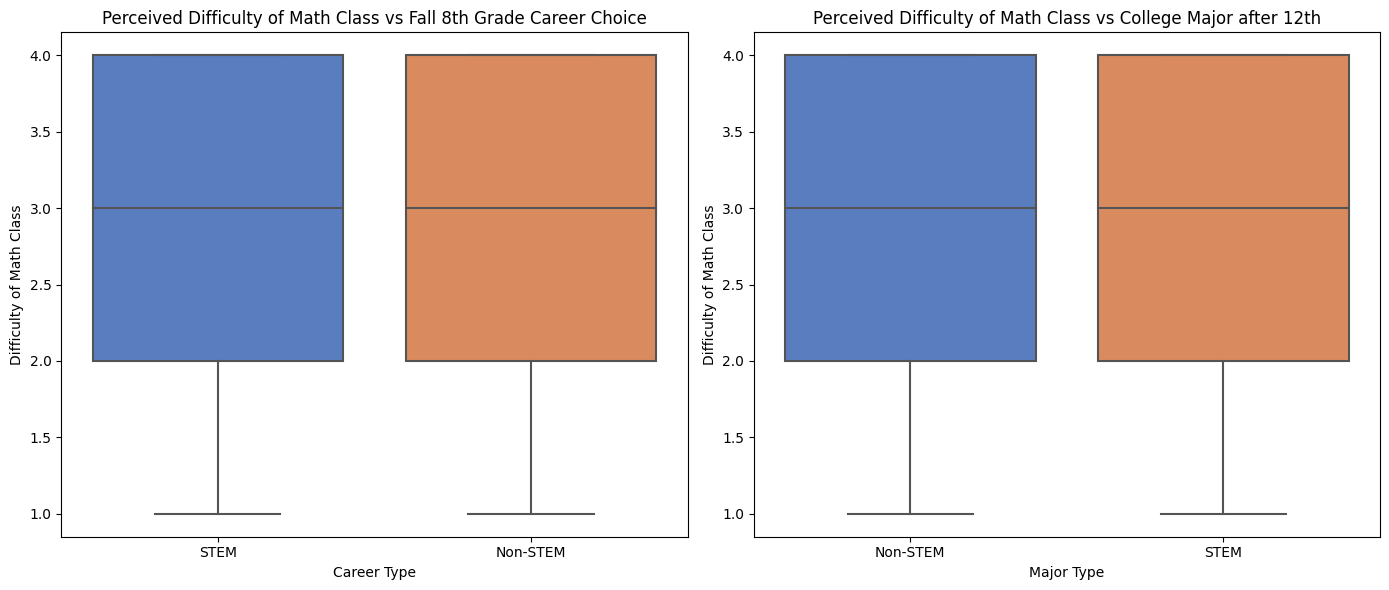

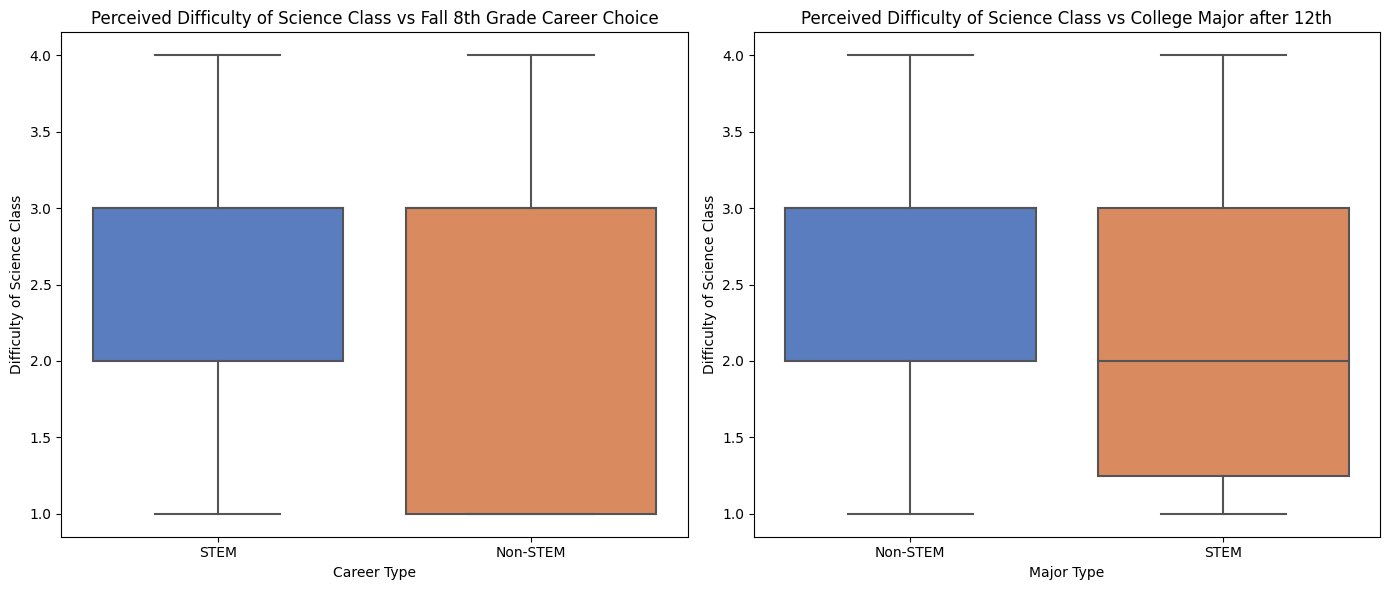

In [12]:
# Enjoyment and difficulty of subjects vs career choices and majors

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='CB19ATXT_type', y='DBMTHC', data=data, palette='muted')
plt.title('Enjoyment of Math Class vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Enjoyment of Math Class')

plt.subplot(1, 2, 2)
sns.boxplot(x='LAMAJOR8I_type', y='DBMTHC', data=data, palette='muted')
plt.title('Enjoyment of Math Class vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Enjoyment of Math Class')

plt.tight_layout()
plt.show()

# Similar analysis for science class enjoyment
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='CB19ATXT_type', y='DBSCIC', data=data, palette='muted')
plt.title('Enjoyment of Science Class vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Enjoyment of Science Class')

plt.subplot(1, 2, 2)
sns.boxplot(x='LAMAJOR8I_type', y='DBSCIC', data=data, palette='muted')
plt.title('Enjoyment of Science Class vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Enjoyment of Science Class')

plt.tight_layout()
plt.show()

# Difficulty perception in math and science
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='CB19ATXT_type', y='DBMTHH', data=data, palette='muted')
plt.title('Perceived Difficulty of Math Class vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Difficulty of Math Class')

plt.subplot(1, 2, 2)
sns.boxplot(x='LAMAJOR8I_type', y='DBMTHH', data=data, palette='muted')
plt.title('Perceived Difficulty of Math Class vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Difficulty of Math Class')

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='CB19ATXT_type', y='DBSCIH', data=data, palette='muted')
plt.title('Perceived Difficulty of Science Class vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Difficulty of Science Class')

plt.subplot(1, 2, 2)
sns.boxplot(x='LAMAJOR8I_type', y='DBSCIH', data=data, palette='muted')
plt.title('Perceived Difficulty of Science Class vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Difficulty of Science Class')

plt.tight_layout()
plt.show()


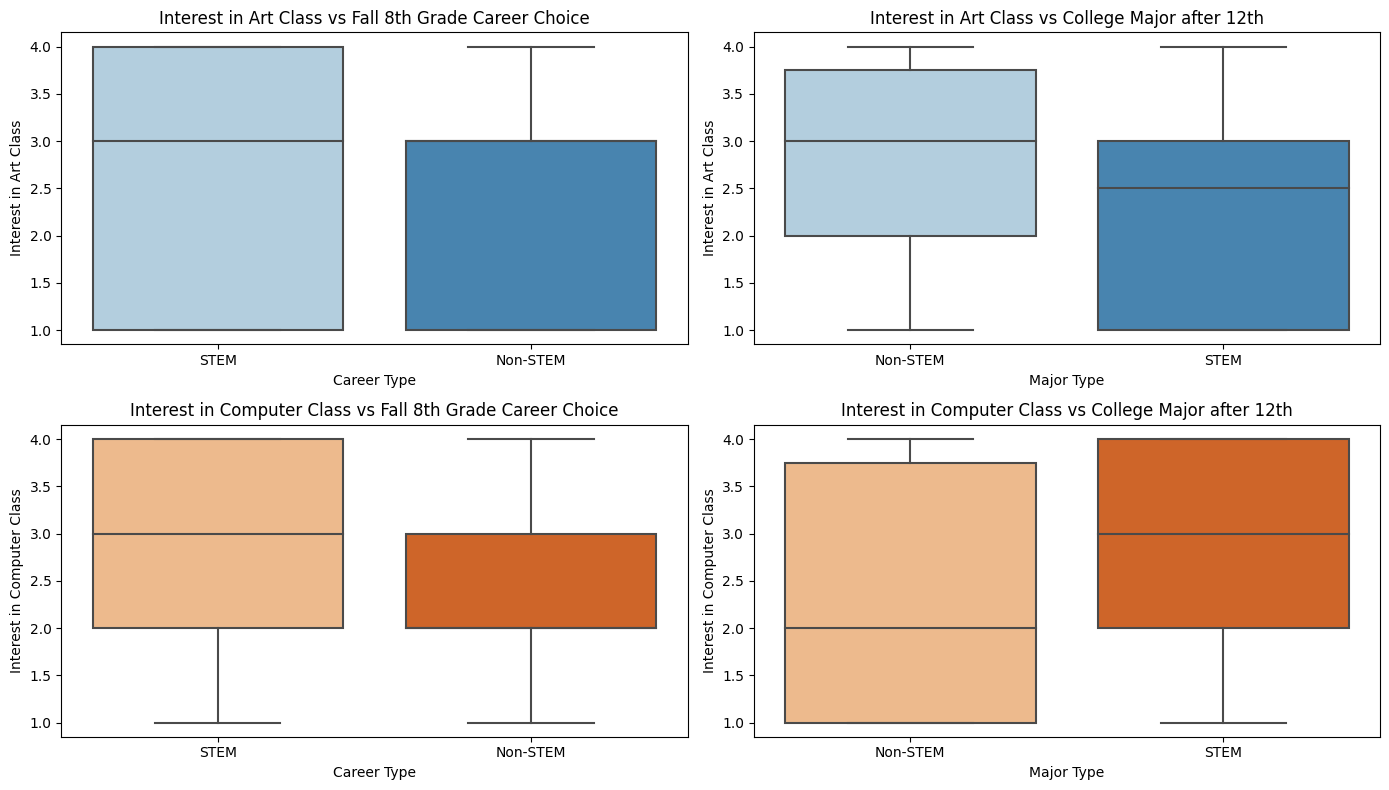

In [13]:
# Interest in different subjects and career choices/college majors

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
sns.boxplot(x='CB19ATXT_type', y='DBARTC', data=data, palette='Blues')
plt.title('Interest in Art Class vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Interest in Art Class')

plt.subplot(2, 2, 2)
sns.boxplot(x='LAMAJOR8I_type', y='DBARTC', data=data, palette='Blues')
plt.title('Interest in Art Class vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Interest in Art Class')

plt.subplot(2, 2, 3)
sns.boxplot(x='CB19ATXT_type', y='DBCOMC', data=data, palette='Oranges')
plt.title('Interest in Computer Class vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Interest in Computer Class')

plt.subplot(2, 2, 4)
sns.boxplot(x='LAMAJOR8I_type', y='DBCOMC', data=data, palette='Oranges')
plt.title('Interest in Computer Class vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Interest in Computer Class')

plt.tight_layout()
plt.show()


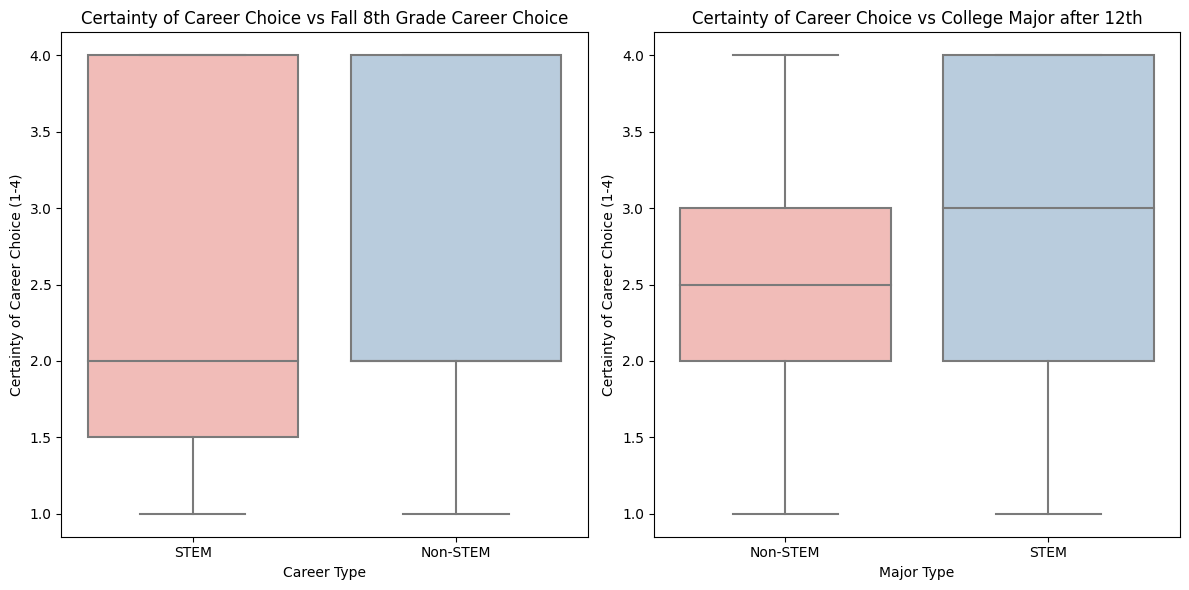

In [14]:
# Career choice certainty and its relationship with career choices and majors

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='CB19ATXT_type', y='CB19C', data=data, palette='Pastel1')
plt.title('Certainty of Career Choice vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Certainty of Career Choice (1-4)')

plt.subplot(1, 2, 2)
sns.boxplot(x='LAMAJOR8I_type', y='DB8C', data=data, palette='Pastel1')
plt.title('Certainty of Career Choice vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Certainty of Career Choice (1-4)')

plt.tight_layout()
plt.show()


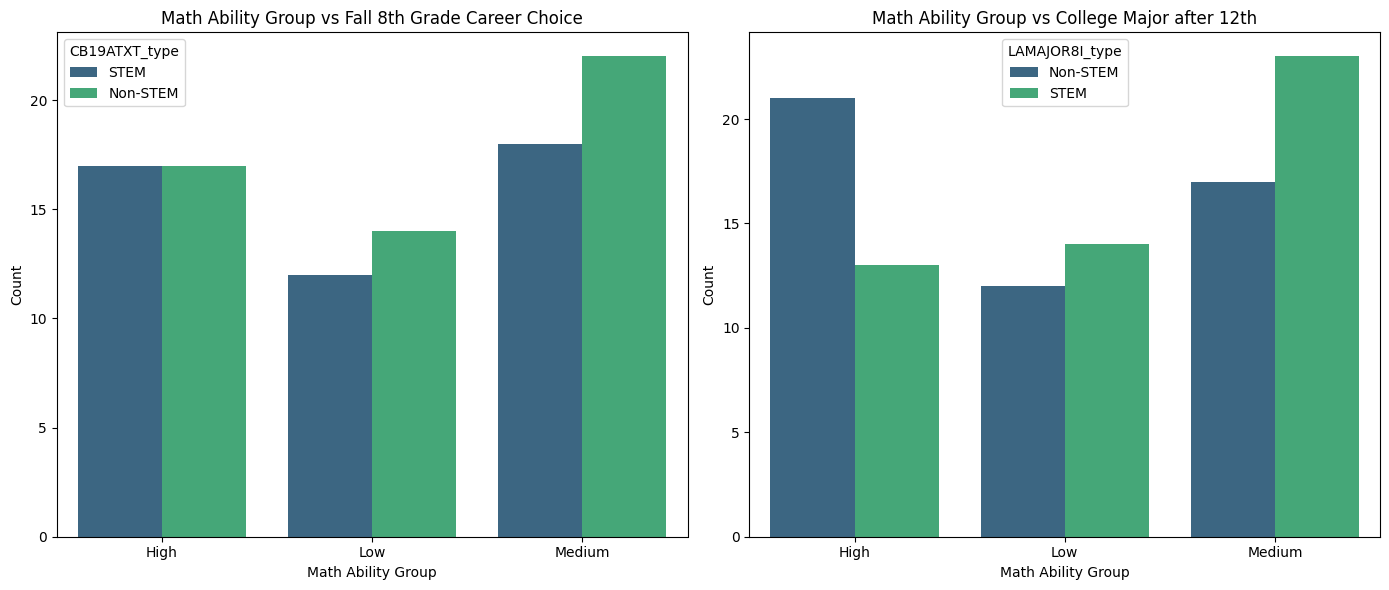

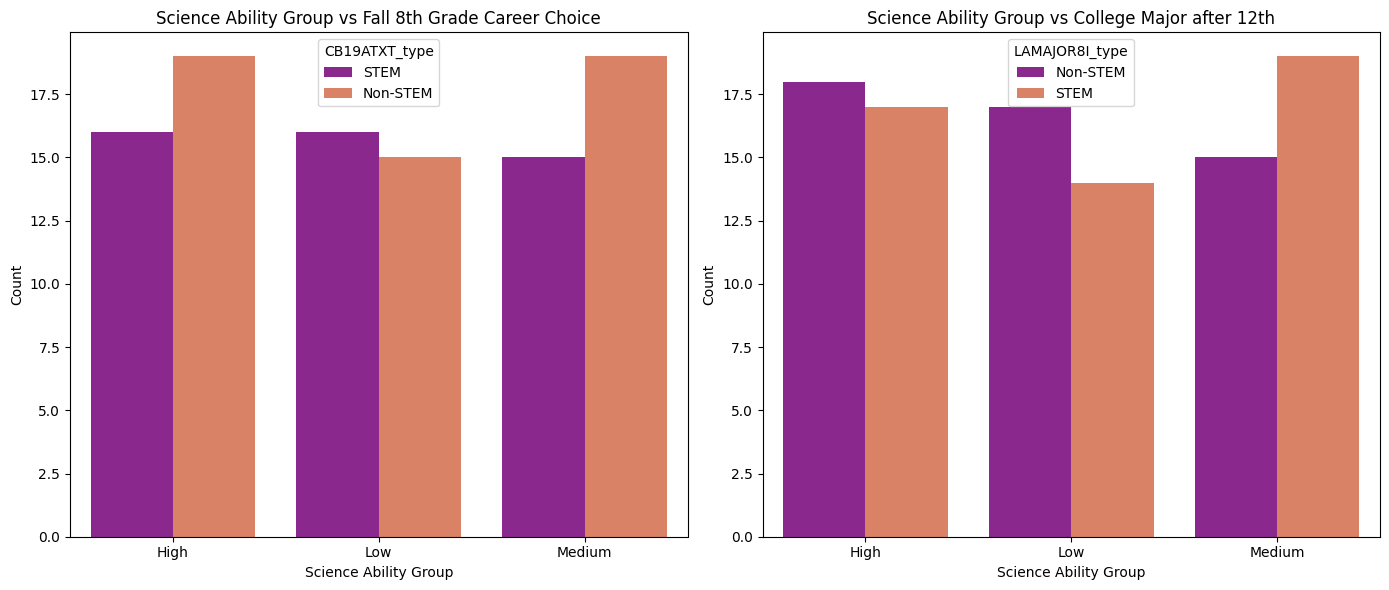

In [15]:
# Ability groups in math and science vs career choices and majors

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='DB6A1', hue='CB19ATXT_type', data=data, palette='viridis')
plt.title('Math Ability Group vs Fall 8th Grade Career Choice')
plt.xlabel('Math Ability Group')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='DB6A1', hue='LAMAJOR8I_type', data=data, palette='viridis')
plt.title('Math Ability Group vs College Major after 12th')
plt.xlabel('Math Ability Group')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Similar analysis for science ability group
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='DB6B1', hue='CB19ATXT_type', data=data, palette='plasma')
plt.title('Science Ability Group vs Fall 8th Grade Career Choice')
plt.xlabel('Science Ability Group')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='DB6B1', hue='LAMAJOR8I_type', data=data, palette='plasma')
plt.title('Science Ability Group vs College Major after 12th')
plt.xlabel('Science Ability Group')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


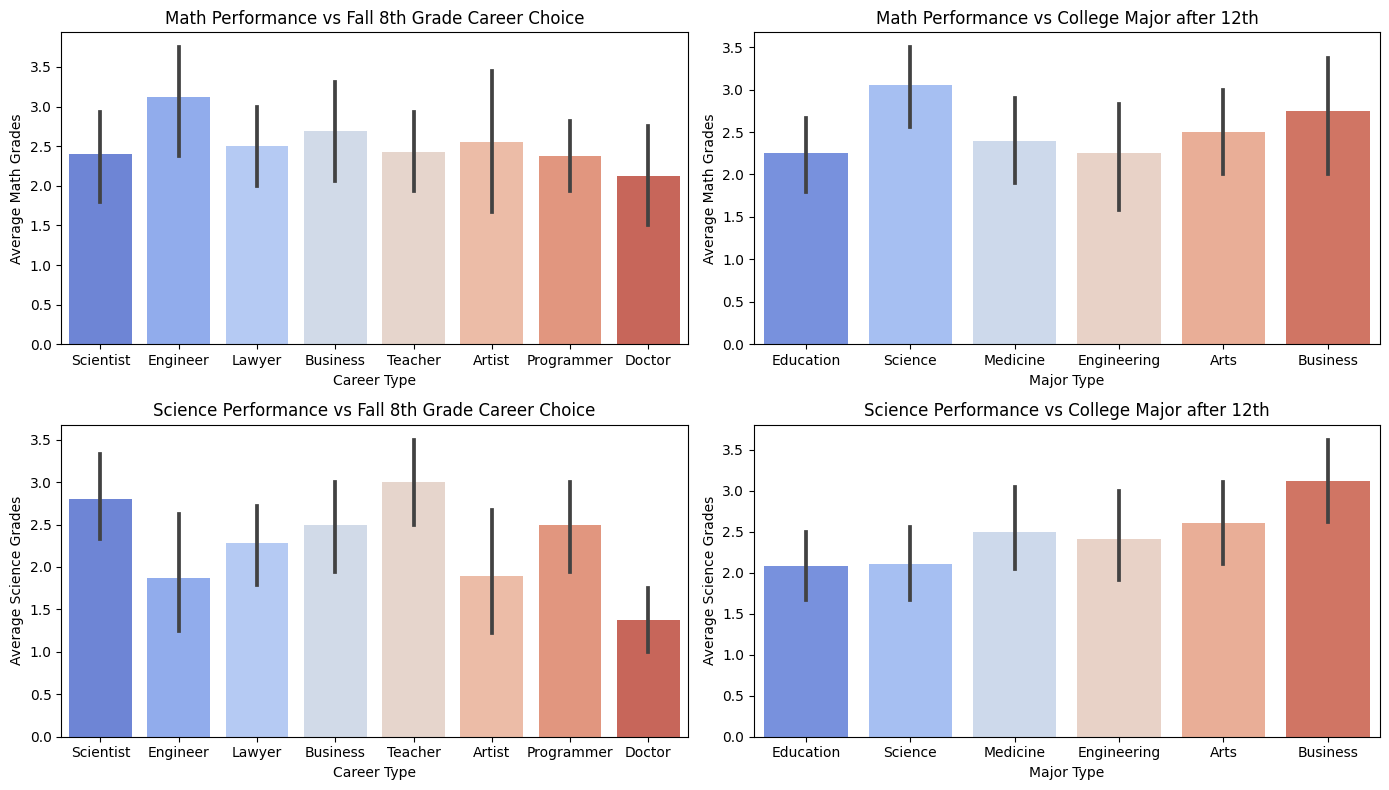

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define function to categorize career choices and majors
def categorize_labels(labels):
    return [label.split()[0] for label in labels]

# Categorize career choices and majors
data['CB19ATXT_type'] = categorize_labels(data['CB19ATXT'])
data['LAMAJOR8I_type'] = categorize_labels(data['LAMAJOR8I'])

# Performance in Math and Science vs Career Choices and Majors
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
sns.barplot(x='CB19ATXT_type', y='CB27B', data=data, palette='coolwarm')
plt.title('Math Performance vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Average Math Grades')

plt.subplot(2, 2, 2)
sns.barplot(x='LAMAJOR8I_type', y='CB27B', data=data, palette='coolwarm')
plt.title('Math Performance vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Average Math Grades')

plt.subplot(2, 2, 3)
sns.barplot(x='CB19ATXT_type', y='CB27C', data=data, palette='coolwarm')
plt.title('Science Performance vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Average Science Grades')

plt.subplot(2, 2, 4)
sns.barplot(x='LAMAJOR8I_type', y='CB27C', data=data, palette='coolwarm')
plt.title('Science Performance vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Average Science Grades')

plt.tight_layout()
plt.show()


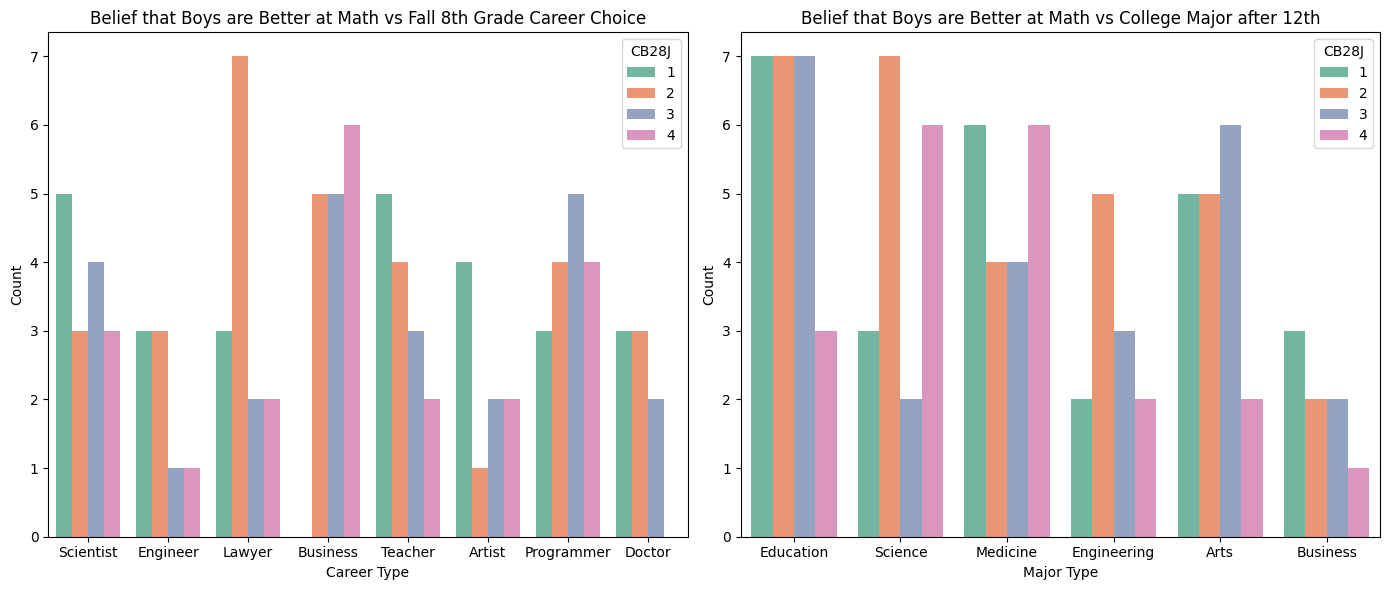

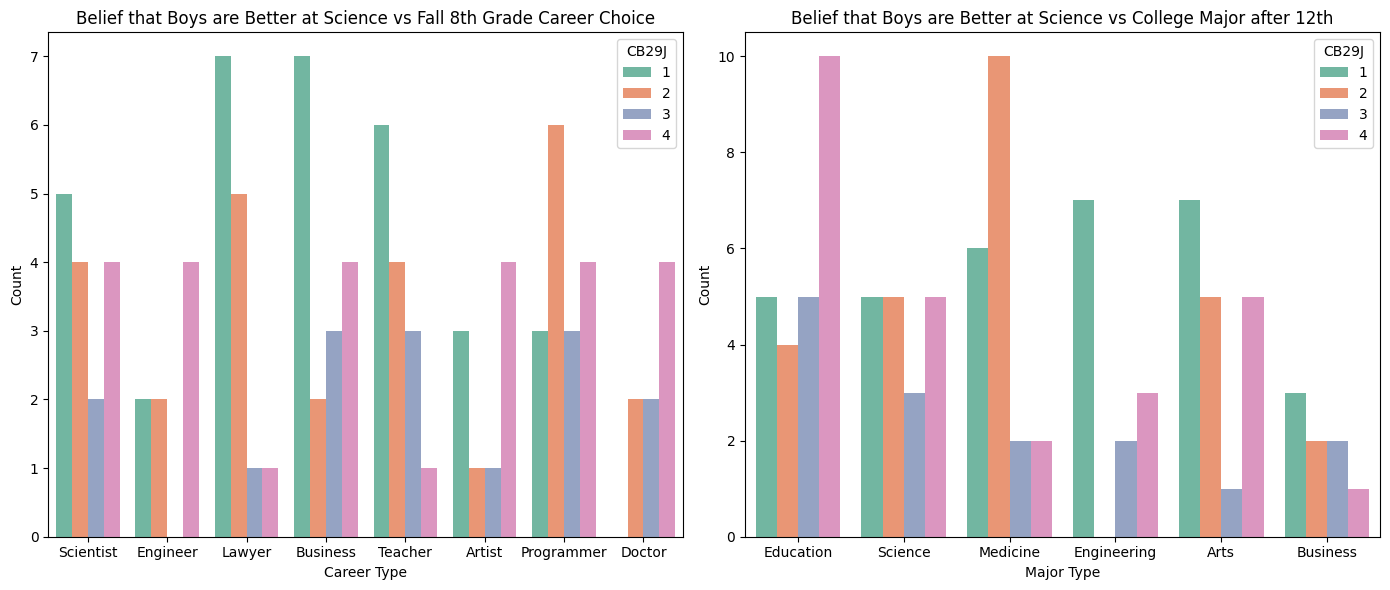

In [17]:
# Gender-based beliefs and career choices

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='CB19ATXT_type', hue='CB28J', data=data, palette='Set2')
plt.title('Belief that Boys are Better at Math vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='LAMAJOR8I_type', hue='CB28J', data=data, palette='Set2')
plt.title('Belief that Boys are Better at Math vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Similar analysis for science
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='CB19ATXT_type', hue='CB29J', data=data, palette='Set2')
plt.title('Belief that Boys are Better at Science vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='LAMAJOR8I_type', hue='CB29J', data=data, palette='Set2')
plt.title('Belief that Boys are Better at Science vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


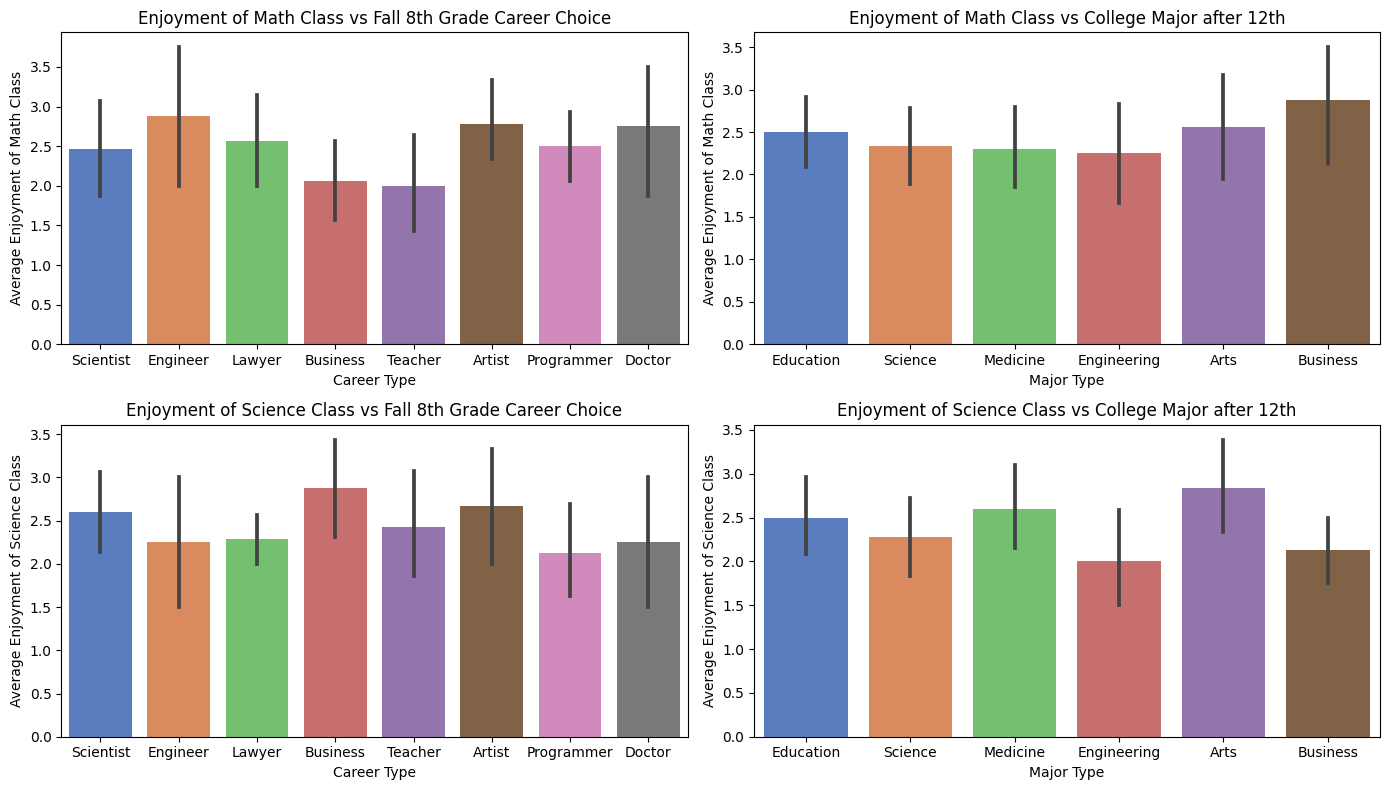

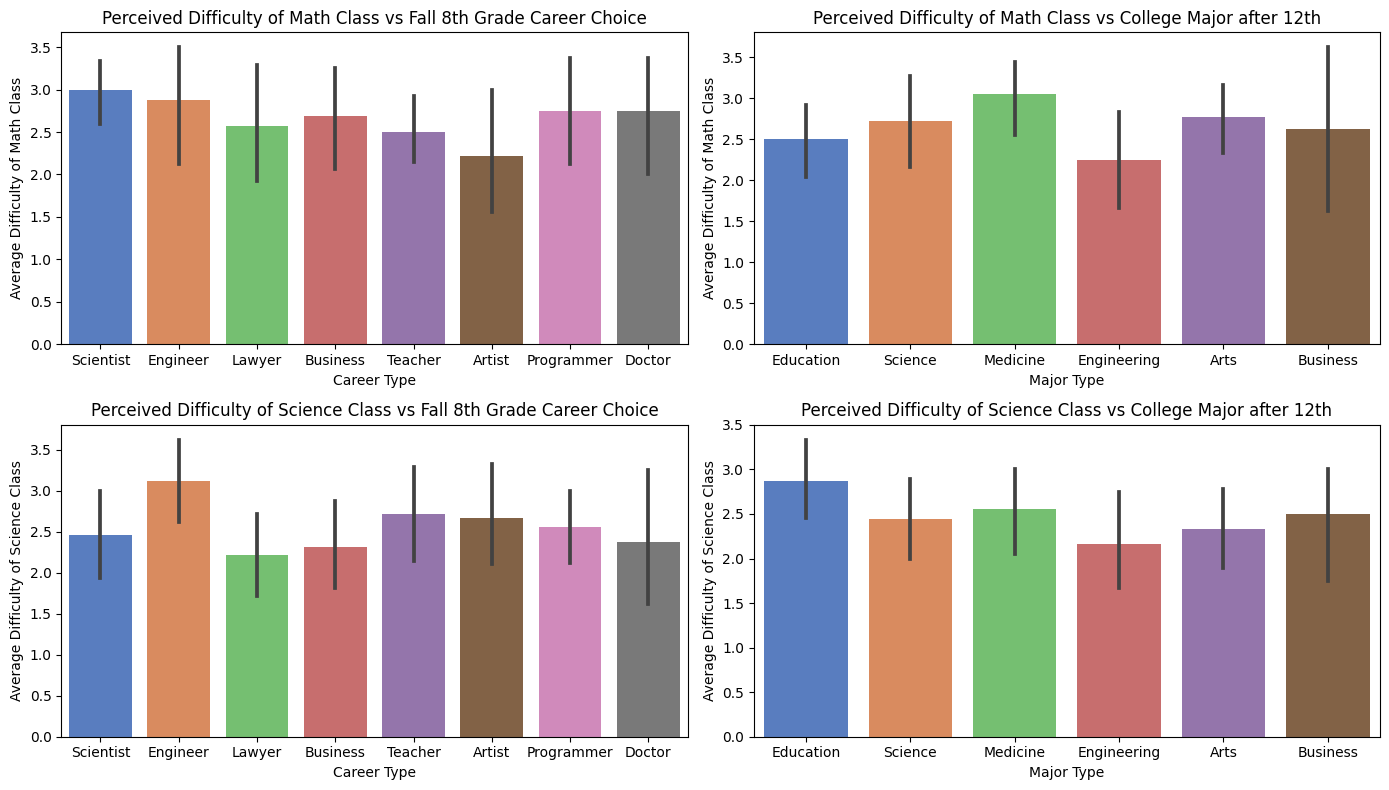

In [18]:
# Enjoyment and difficulty of subjects vs career choices and majors

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
sns.barplot(x='CB19ATXT_type', y='DBMTHC', data=data, palette='muted')
plt.title('Enjoyment of Math Class vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Average Enjoyment of Math Class')

plt.subplot(2, 2, 2)
sns.barplot(x='LAMAJOR8I_type', y='DBMTHC', data=data, palette='muted')
plt.title('Enjoyment of Math Class vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Average Enjoyment of Math Class')

plt.subplot(2, 2, 3)
sns.barplot(x='CB19ATXT_type', y='DBSCIC', data=data, palette='muted')
plt.title('Enjoyment of Science Class vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Average Enjoyment of Science Class')

plt.subplot(2, 2, 4)
sns.barplot(x='LAMAJOR8I_type', y='DBSCIC', data=data, palette='muted')
plt.title('Enjoyment of Science Class vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Average Enjoyment of Science Class')

plt.tight_layout()
plt.show()

# Perceived difficulty in math and science
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
sns.barplot(x='CB19ATXT_type', y='DBMTHH', data=data, palette='muted')
plt.title('Perceived Difficulty of Math Class vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Average Difficulty of Math Class')

plt.subplot(2, 2, 2)
sns.barplot(x='LAMAJOR8I_type', y='DBMTHH', data=data, palette='muted')
plt.title('Perceived Difficulty of Math Class vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Average Difficulty of Math Class')

plt.subplot(2, 2, 3)
sns.barplot(x='CB19ATXT_type', y='DBSCIH', data=data, palette='muted')
plt.title('Perceived Difficulty of Science Class vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Average Difficulty of Science Class')

plt.subplot(2, 2, 4)
sns.barplot(x='LAMAJOR8I_type', y='DBSCIH', data=data, palette='muted')
plt.title('Perceived Difficulty of Science Class vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Average Difficulty of Science Class')

plt.tight_layout()
plt.show()


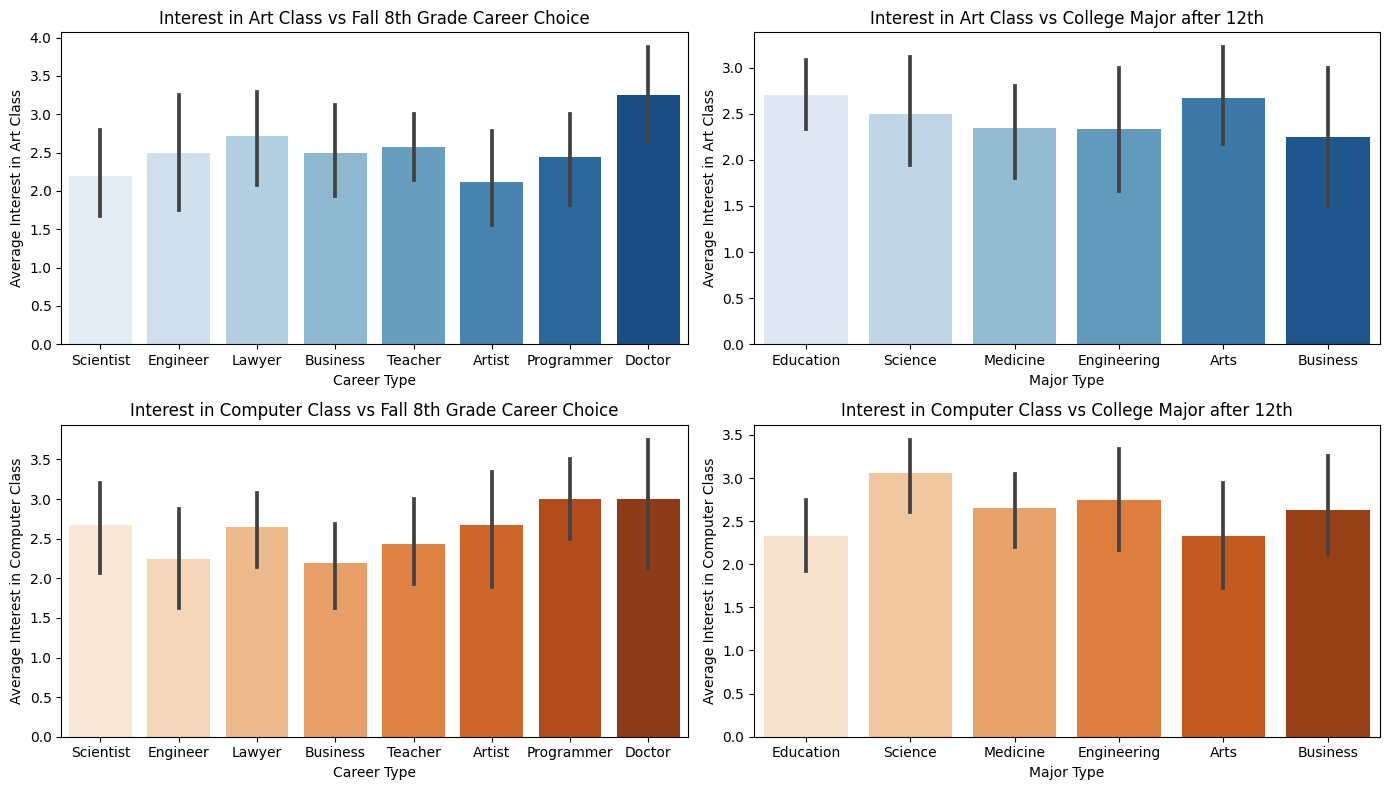

In [20]:
# Interest in different subjects and career choices/college majors

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
sns.barplot(x='CB19ATXT_type', y='DBARTC', data=data, palette='Blues')
plt.title('Interest in Art Class vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Average Interest in Art Class')

plt.subplot(2, 2, 2)
sns.barplot(x='LAMAJOR8I_type', y='DBARTC', data=data, palette='Blues')
plt.title('Interest in Art Class vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Average Interest in Art Class')

plt.subplot(2, 2, 3)
sns.barplot(x='CB19ATXT_type', y='DBCOMC', data=data, palette='Oranges')
plt.title('Interest in Computer Class vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Average Interest in Computer Class')

plt.subplot(2, 2, 4)
sns.barplot(x='LAMAJOR8I_type', y='DBCOMC', data=data, palette='Oranges')
plt.title('Interest in Computer Class vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Average Interest in Computer Class')

plt.tight_layout()
plt.show()


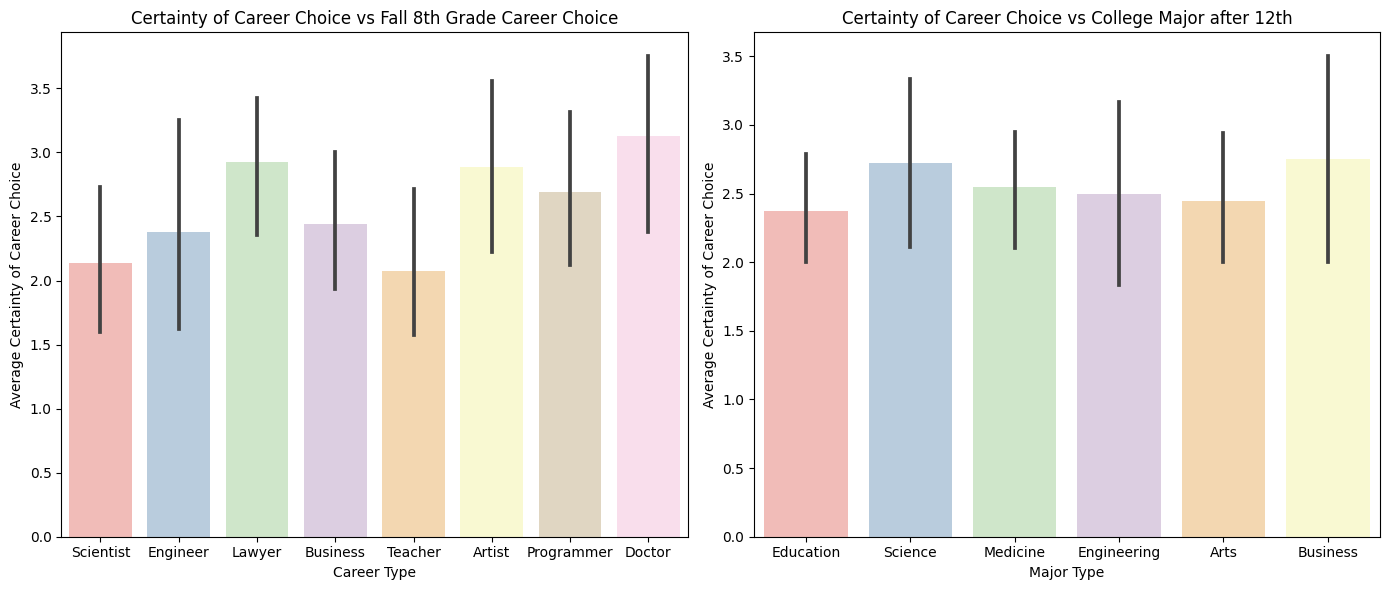

In [21]:
# Career choice certainty and its relationship with career choices and majors

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='CB19ATXT_type', y='CB19C', data=data, palette='Pastel1')
plt.title('Certainty of Career Choice vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Average Certainty of Career Choice')

plt.subplot(1, 2, 2)
sns.barplot(x='LAMAJOR8I_type', y='DB8C', data=data, palette='Pastel1')
plt.title('Certainty of Career Choice vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Average Certainty of Career Choice')

plt.tight_layout()
plt.show()


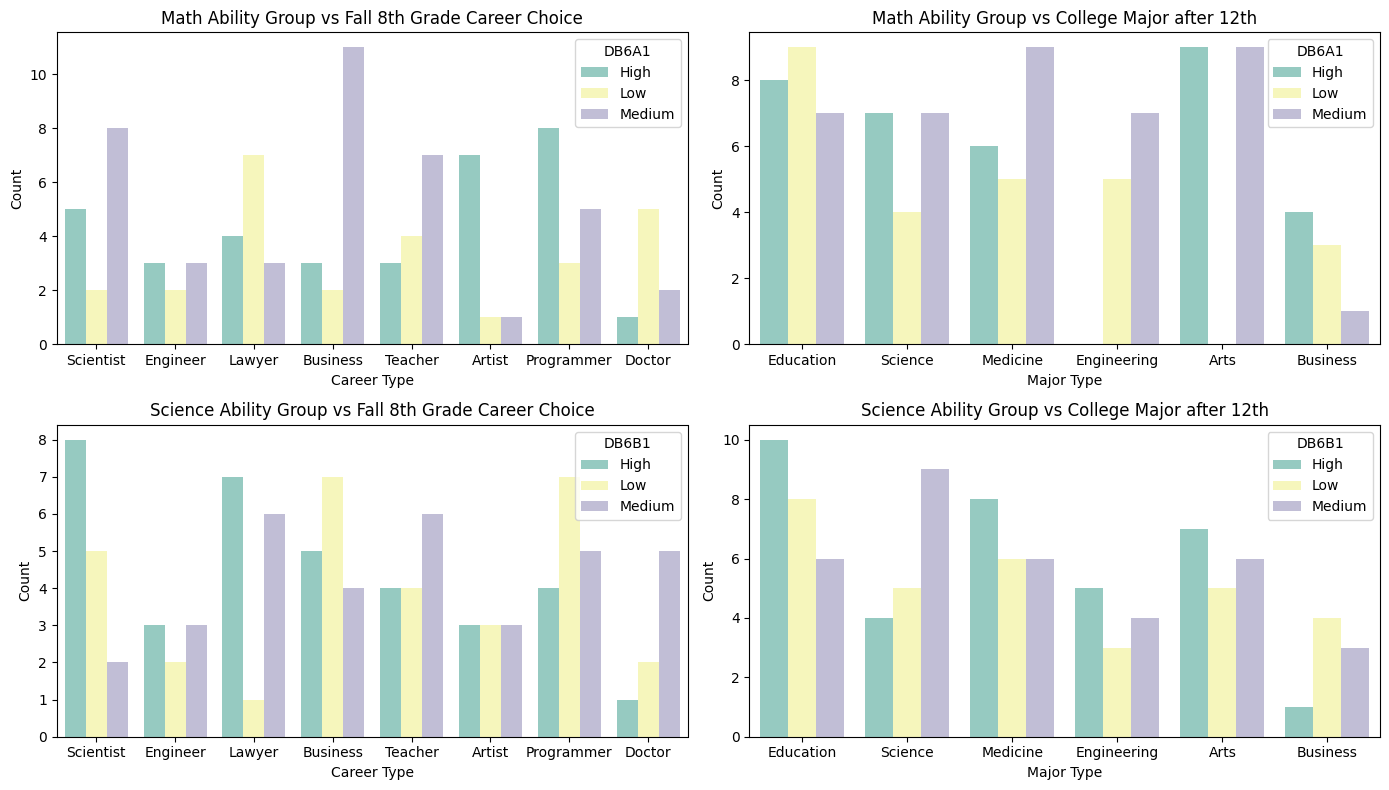

In [22]:
# Ability groups in math and science vs career choices and majors

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
sns.countplot(x='CB19ATXT_type', hue='DB6A1', data=data, palette='Set3')
plt.title('Math Ability Group vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Count')

plt.subplot(2, 2, 2)
sns.countplot(x='LAMAJOR8I_type', hue='DB6A1', data=data, palette='Set3')
plt.title('Math Ability Group vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Count')

plt.subplot(2, 2, 3)
sns.countplot(x='CB19ATXT_type', hue='DB6B1', data=data, palette='Set3')
plt.title('Science Ability Group vs Fall 8th Grade Career Choice')
plt.xlabel('Career Type')
plt.ylabel('Count')

plt.subplot(2, 2, 4)
sns.countplot(x='LAMAJOR8I_type', hue='DB6B1', data=data, palette='Set3')
plt.title('Science Ability Group vs College Major after 12th')
plt.xlabel('Major Type')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


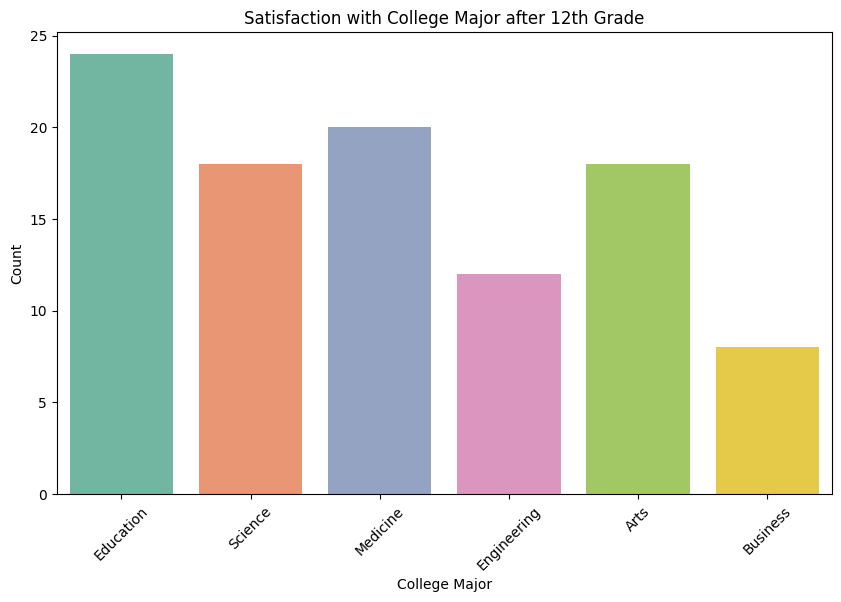

In [23]:
# Satisfaction with college major

plt.figure(figsize=(10, 6))
sns.countplot(x='LAMAJOR8I', data=data, palette='Set2')
plt.title('Satisfaction with College Major after 12th Grade')
plt.xlabel('College Major')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
